In [1]:
from bids import BIDSLayout
import pandas as pd
import numpy as np
import scipy
import json
import pyedflib

In [2]:
# Load dataset
data_path = '/scratch/mcesped/code/sEEGPrep/Results/hipp_run/bids/'
layout = BIDSLayout(data_path, validate=False)

In [3]:
# How to get edf files
len(layout.get(extension='edf', suffix='ieeg', return_type='filename'))

115

In [4]:
# Get all json files
json_files = layout.get(extension='json')
json_files[0:3]

[<BIDSJSONFile filename='/scratch/mcesped/code/sEEGPrep/Results/hipp_run/bids/sub-002/ses-002/ieeg/sub-002_ses-002_task-full_rec-regionID_run-01_regions_native_space.json'>,
 <BIDSJSONFile filename='/scratch/mcesped/code/sEEGPrep/Results/hipp_run/bids/sub-003/ses-007/ieeg/sub-003_ses-007_task-full_rec-regionID_run-02_regions_native_space.json'>,
 <BIDSJSONFile filename='/scratch/mcesped/code/sEEGPrep/Results/hipp_run/bids/sub-003/ses-008/ieeg/sub-003_ses-008_task-full_rec-regionID_run-01_regions_native_space.json'>]

In [5]:
# How to get filenames
json_files[0].path

'/scratch/mcesped/code/sEEGPrep/Results/hipp_run/bids/sub-002/ses-002/ieeg/sub-002_ses-002_task-full_rec-regionID_run-01_regions_native_space.json'

In [ ]:
json_files[0].get_entities()['session']

In [ ]:
json_files[0].get_entities()['subject']

In [ ]:
# Open json
with open(json_files[0].path, 'r') as f:
  data_json = json.load(f)

In [ ]:
for key in data_json:
    keys_chn = list(data_json[key].keys())
    if keys_chn[0] != 'Unknown':
        print(key)

In [3]:
sub_sess_info = dict()
json_files = layout.get(extension='json')
for json_file in json_files:
    # Open json
    with open(json_file.path, 'r') as f:
      data_json = json.load(f)
    # Filter data in dict
    new_dict = data_json.copy()
    for key in data_json:
        keys_chn = list(data_json[key].keys())
        # Filter unknown
        if keys_chn[0] == 'Unknown':
            del new_dict[key]
    # Extract edf files
    subj = json_file.get_entities()['subject']
    session = json_file.get_entities()['session']
    edf_files = layout.get(extension='edf', suffix='ieeg', subject=subj, session=session, return_type='filename')
    loc_file = layout.get(extension='tsv', suffix='space', subject=subj, session=session, return_type='filename')
    if len(loc_file)>1:
        print('Ups this is wrong')
    # Append to dict
    sub_sess_info[f'sub-{subj}_ses-{session}'] = {
        'channels_tsv': loc_file[0],
        'edf_files' : edf_files,
        'chn_info': new_dict,
        'subject': subj
    }

In [4]:
sub_sess_info[list(sub_sess_info.keys())[3]]

{'channels_tsv': '/scratch/mcesped/code/sEEGPrep/Results/hipp_run/bids/sub-004/ses-001/ieeg/sub-004_ses-001_task-full_rec-regionID_run-01_regions_native_space.tsv',
 'edf_files': ['/scratch/mcesped/code/sEEGPrep/Results/hipp_run/bids/sub-004/ses-001/ieeg/sub-004_ses-001_task-full_rec-regionID_run-01_clip-01_ieeg.edf'],
 'chn_info': {'LPHc2-3': {'CA1': 0.48, 'Unknown': 0.46, 'CA2': 0.07},
  'LAHc1-2': {'subiculum': 0.5,
   'CA1': 0.28,
   "SRLM or 'dark band'": 0.16,
   'Unknown': 0.06},
  'LAHc2-3': {'CA1': 0.79, 'Unknown': 0.17, "SRLM or 'dark band'": 0.05},
  'RAHc1-2': {"SRLM or 'dark band'": 0.78,
   'dentate gyrus': 0.16,
   'CA4': 0.03,
   'cysts': 0.03},
  'RAHc2-3': {"SRLM or 'dark band'": 0.69,
   'CA1': 0.25,
   'CA4': 0.03,
   'cysts': 0.03},
  'RAHc3-4': {'CA1': 0.57, 'Unknown': 0.32, "SRLM or 'dark band'": 0.11}},
 'subject': '004'}

In [5]:
len(sub_sess_info)

115

In [6]:
regions = ["subiculum", "CA1", "CA2", "CA3", "CA4", "dentate gyrus", "SRLM or 'dark band'", "cysts"]

In [7]:
# Load snsx data
snsx_path = './snsx_data_collection.csv'
snsx_df = pd.read_csv(snsx_path, sep=',')
# Load mapping snsx to clinical
mapping = pd.read_csv('mapping_snsx_clinical.tsv', sep='\t')
mapping_dict = dict(zip(mapping['ieeg_subject'].to_list(), mapping['snsx_subject'].to_list()))
# Create new dict with data per labels
data_per_region = dict()
subj_per_region = dict()
chn_per_region = dict()
for sub_sess in sub_sess_info:
    # Get bad hemispheres
    subj_clinical = sub_sess_info[sub_sess]['subject']
    subj_snsx = mapping_dict[f"sub-P{subj_clinical}"]
    # print(subj_snsx)
    bilobal, bad_R, bad_L = snsx_df[snsx_df['participant_id']==subj_snsx][['Bilobal', 'Right ', 'Left']].to_numpy().squeeze().astype(bool)
    # print(bad_R, bad_L)
    # Get labels of electrodes with main region
    chn_region = []
    for chn in sub_sess_info[sub_sess]['chn_info']:
        chn_info = sub_sess_info[sub_sess]['chn_info'][chn]
        chn_region.append((chn, list(chn_info.keys())[0]))
    # Get info from channels.tsv
    loc_df = pd.read_csv(sub_sess_info[sub_sess]['channels_tsv'], sep='\t')
    # Get info per edf file
    for edf_path in sub_sess_info[sub_sess]['edf_files']:
        edf = pyedflib.EdfReader(edf_path)
        # Get chn labels
        edf_chns = edf.getSignalLabels()
        for chn, region in chn_region:
            # Check if the channel is in a good hemi
            # Right hemi
            cond_R = (loc_df[loc_df['label']==chn]['x_init'].values[0] > 0) and (loc_df[loc_df['label']==chn]['x_end'].values[0] > 0) and not bad_R
            # Left hemi
            cond_L = (loc_df[loc_df['label']==chn]['x_init'].values[0] < 0) and (loc_df[loc_df['label']==chn]['x_end'].values[0] < 0) and not bad_L
            if not bilobal and (cond_R or cond_L):
                # print(cond_R, cond_L)
                # print(chn)
                data = edf.readSignal(edf_chns.index(chn))
                if region in data_per_region:
                    data_per_region[region].append(data)
                    subj_per_region[region].append(subj_clinical)
                    chn_per_region[region].append(chn)
                else:
                    data_per_region[region] = [data]
                    subj_per_region[region] = [subj_clinical]
                    chn_per_region[region] = [chn]
        edf.close()

In [41]:
edf.close()

In [23]:
print(data_per_region.keys())
print(subj_per_region.keys())

dict_keys(["SRLM or 'dark band'", 'CA1', 'CA3'])
dict_keys(["SRLM or 'dark band'", 'CA1', 'CA3'])


In [8]:
for region in data_per_region:
    data_per_region[region] = np.array(data_per_region[region])
    subj_per_region[region] = np.array(subj_per_region[region])
    chn_per_region[region] = np.array(chn_per_region[region])

## Plot figures

### Functions

In [9]:
import plotly.graph_objects as go
import scipy
import scipy.io as sio
import scipy.fftpack
import scipy.signal
import copy
import os
from sklearn.metrics import mean_squared_error
import re
import matplotlib.pyplot as plt

In [10]:
def plotPaperFigures(freq, welchpow, out_path=None, output=False, show_fig='Close', ax=None, title=None):
    # welchpow: n_chans x n_samples
    # Get median:
    median_welchpow = np.median(welchpow, axis=0)
    # Get std
    n_samples = welchpow.shape[1]
    std = np.zeros(n_samples)
    mean = np.zeros(n_samples)
    for i in range(n_samples):
        (mean[i], std[i]) = scipy.stats.norm.fit(welchpow[:,i].squeeze())
    # Get quartiles
    quant = np.quantile(welchpow, [0.25, 0.75], axis=0)
    # Get max and min
    max_pow = np.max(welchpow, axis=0)
    min_pow = np.min(welchpow, axis=0)

    # Plot
    x_val = [0.5, 4, 8, 13, 30, 80]
    default_x_ticks = range(len(x_val))
    if ax == None:
        fig, ax = plt.subplots()
    ax.semilogx(freq, median_welchpow, 'r')
    ax.fill_between(freq,
                    quant[0,:],
                    quant[1, :],
                    alpha=0.2, color='tab:pink')
    ax.semilogx(freq, max_pow, '--', color='tab:orange')
    ax.semilogx(freq, min_pow, '--', color='tab:orange')
    ax.semilogx([4, 4], [0, 1.1], '--k')
    ax.semilogx([8, 8], [0, 1.1], '--k')
    ax.semilogx([13, 13], [0, 1.1], '--k')
    ax.semilogx([30, 30], [0, 1.1], '--k')
    ax.set_xticks(x_val)
    ax.set_xticklabels(x_val)
    ax.set_xlim([0.5,80])
    ax.set_ylim([0, 1])
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('Power')
    if title:
        ax.set_title(title)
    # ax.set_xscale('log')
    if output:
        fig.savefig(out_path)
    if show_fig=='Close':
        plt.close()
    elif show_fig == True:
        plt.show()
    return median_welchpow, mean, std

In [11]:
import scipy.signal
def welchMethod(data, srate):
    # create Hann window
    win_seconds = 2.0
    winsize = int( win_seconds*srate ) # 2-second window
    hannw = .5 - np.cos(2*np.pi*np.linspace(0,1,winsize))/2

    # number of FFT points (frequency resolution)
    spectres = 0.5; # Hz
    nfft = int(srate/spectres)
    # print('hihi')
    # Apply Welch method
    f, welchpow = scipy.signal.welch(data,fs=srate,window=hannw,
                                    nperseg=winsize,noverlap=winsize/2,nfft=nfft, scaling='density')
    print(welchpow.shape)
    # Normalizing
    if welchpow.ndim > 1:
        welchpow = np.divide(welchpow, np.sqrt(np.sum(welchpow**2, axis=1)).reshape(welchpow.shape[0],1))
    else:
        welchpow = np.divide(welchpow, np.sqrt(np.sum(welchpow**2)))
    
    # Crop the signal
    min_freq = 1/win_seconds
    max_freq = 80 
    min_id = np.argmin(np.abs(f-min_freq))
    max_id = np.argmin(np.abs(f-max_freq))
    
    if welchpow.ndim > 1:
        return f[min_id:max_id], welchpow[:,min_id:max_id]
    else:
        return f[min_id:max_id], welchpow[min_id:max_id]

In [12]:
psd_per_region = dict()
f_per_region =  dict()
for region in data_per_region:
    f_per_region[region], psd_per_region[region] = welchMethod(data_per_region[region], 200)

(25, 201)
(68, 201)
(14, 201)


SRLM or 'dark band'
['003' '003' '004' '004' '004' '004' '004' '004' '004' '004' '016' '016'
 '016' '016' '016' '016' '016' '016' '016' '068' '068' '068' '068' '068'
 '068']
['LAHc1-2' 'LAHc1-2' 'RAHc1-2' 'RAHc2-3' 'RAHc1-2' 'RAHc2-3' 'RAHc1-2'
 'RAHc2-3' 'RAHc1-2' 'RAHc2-3' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2'
 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RHc1-2' 'RHc1-2'
 'RHc1-2' 'RHc1-2' 'RHc1-2' 'RHc1-2']


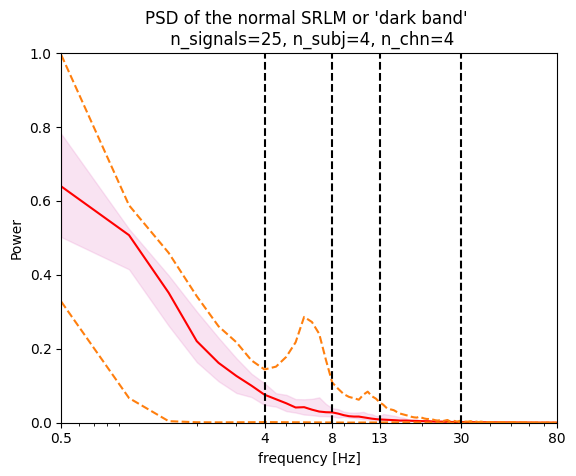

CA1
['004' '004' '004' '004' '016' '016' '016' '016' '016' '016' '016' '016'
 '016' '016' '016' '016' '067' '067' '067' '067' '067' '078' '078' '078'
 '078' '078' '078' '078' '078' '078' '078' '078' '078' '078' '078' '078'
 '078' '078' '078' '078' '078' '078' '078' '078' '078' '078' '078' '078'
 '083' '083' '083' '083' '083' '083' '083' '083' '083' '083' '083' '093'
 '093' '093' '093' '093' '093' '093' '093' '093']
['RAHc3-4' 'RAHc3-4' 'RAHc3-4' 'RAHc3-4' 'RAHc2-3' 'RAHc2-3' 'RPHc1-2'
 'RAHc2-3' 'RPHc1-2' 'RAHc2-3' 'RPHc1-2' 'RAHc2-3' 'RAHc2-3' 'RAHc2-3'
 'RAHc2-3' 'RAHc2-3' 'RPHc3-4' 'RPHc3-4' 'RPHc3-4' 'RPHc3-4' 'RPHc3-4'
 'LAHc1-2' 'LAHc2-3' 'LAHc3-4' 'LAHc1-2' 'LAHc2-3' 'LAHc3-4' 'LAHc1-2'
 'LAHc2-3' 'LAHc3-4' 'LAHc1-2' 'LAHc2-3' 'LAHc3-4' 'LAHc1-2' 'LAHc2-3'
 'LAHc3-4' 'LAHc1-2' 'LAHc2-3' 'LAHc3-4' 'LAHc1-2' 'LAHc2-3' 'LAHc3-4'
 'LAHc1-2' 'LAHc2-3' 'LAHc3-4' 'LAHc1-2' 'LAHc2-3' 'LAHc3-4' 'RPHc1-2'
 'RPHc1-2' 'RPHc1-2' 'RPHc1-2' 'RPHc1-2' 'RPHc1-2' 'RPHc1-2' 'RPHc1-2'
 'RPHc1-2' 'R

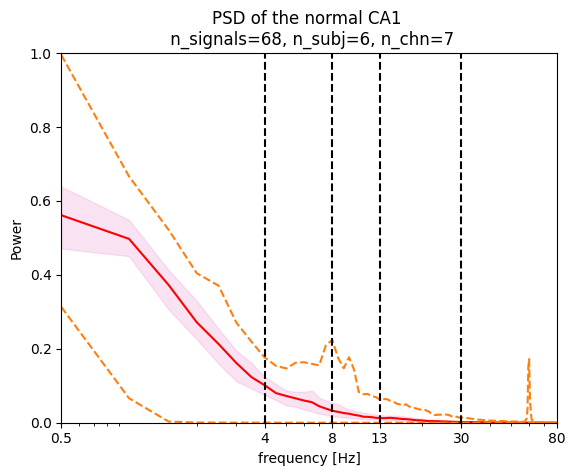

CA3
['067' '067' '067' '067' '067' '093' '093' '093' '093' '093' '093' '093'
 '093' '093']
['RPHc2-3' 'RPHc2-3' 'RPHc2-3' 'RPHc2-3' 'RPHc2-3' 'RAHc1-2' 'RAHc1-2'
 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2']


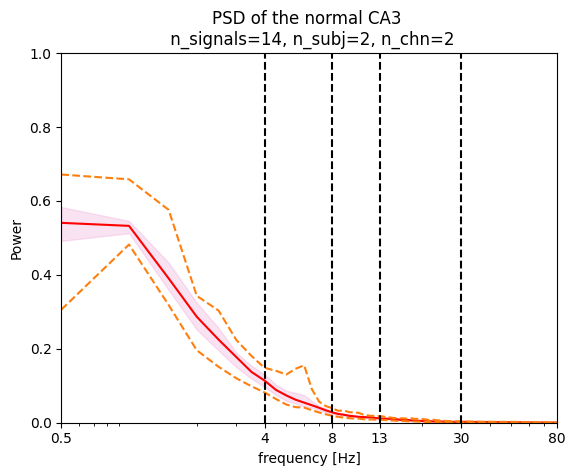

In [13]:
# Extract median, mean and std
median_region = {}
std_region = {}
mean_region = {}
for region in psd_per_region:
    # Extract data
    print(region)
    print(subj_per_region[region])
    print(chn_per_region[region])
    psd = psd_per_region[region]
    f = f_per_region[region]
    # # Plot and save the median curve
    n_subj = len(np.unique(subj_per_region[region]))
    n_chn = len(np.unique(chn_per_region[region]))
    median, mean, std = plotPaperFigures(f, psd, show_fig=True, title=f'PSD of the normal {region} \n n_signals={psd.shape[0]}, n_subj={n_subj}, n_chn={n_chn}')
    median_region[region] = median
    std_region[region] = std
    mean_region[region] = mean

## Abnormal signals

In [32]:
# Load snsx data
snsx_path = './snsx_data_collection.csv'
snsx_df = pd.read_csv(snsx_path, sep=',')
# Load mapping snsx to clinical
mapping = pd.read_csv('mapping_snsx_clinical.tsv', sep='\t')￼
abn_subj_per_region = dict()
abn_chn_per_region = dict()
for sub_sess in sub_sess_info:
    # Get bad hemispheres
    subj_clinical = sub_sess_info[sub_sess]['subject']
    subj_snsx = mapping_dict[f"sub-P{subj_clinical}"]
    # print(subj_snsx)
    bilobal, bad_R, bad_L = snsx_df[snsx_df['participant_id']==subj_snsx][['Bilobal', 'Right ', 'Left']].to_numpy().squeeze().astype(bool)
    # print(bad_R, bad_L)
    # Get labels of electrodes with main region
    chn_region = []
    for chn in sub_sess_info[sub_sess]['chn_info']:
        chn_info = sub_sess_info[sub_sess]['chn_info'][chn]
        chn_region.append((chn, list(chn_info.keys())[0]))
    # Get info from channels.tsv
    loc_df = pd.read_csv(sub_sess_info[sub_sess]['channels_tsv'], sep='\t')
    # Get info per edf file
    for edf_path in sub_sess_info[sub_sess]['edf_files']:
        edf = pyedflib.EdfReader(edf_path)
        # Get chn labels
        edf_chns = edf.getSignalLabels()
        for chn, region in chn_region:
            # Check if the channel is in a good hemi
            # Right hemi
            cond_R = (loc_df[loc_df['label']==chn]['x_init'].values[0] > 0) and (loc_df[loc_df['label']==chn]['x_end'].values[0] > 0) and bad_R
            # Left hemi
            cond_L = (loc_df[loc_df['label']==chn]['x_init'].values[0] < 0) and (loc_df[loc_df['label']==chn]['x_end'].values[0] < 0) and bad_L
            if bilobal or (cond_R or cond_L):
                # print(cond_R, cond_L)
                # print(chn)
                data = edf.readSignal(edf_chns.index(chn))
                if region in abn_data_per_region:
                    abn_data_per_region[region].append(data)
                    abn_subj_per_region[region].append(subj_clinical)
                    abn_chn_per_region[region].append(chn)
                else:
                    abn_data_per_region[region] = [data]
                    abn_subj_per_region[region] = [subj_clinical]
                    abn_chn_per_region[region] = [chn]
        edf.close()

In [33]:
print(abn_data_per_region.keys())
print(abn_subj_per_region.keys())

dict_keys(['CA4', "SRLM or 'dark band'", 'CA1', 'subiculum', 'CA3', 'dentate gyrus'])
dict_keys(['CA4', "SRLM or 'dark band'", 'CA1', 'subiculum', 'CA3', 'dentate gyrus'])


In [34]:
for region in abn_data_per_region:
    abn_data_per_region[region] = np.array(abn_data_per_region[region])
    abn_subj_per_region[region] = np.array(abn_subj_per_region[region])
    abn_chn_per_region[region] = np.array(abn_chn_per_region[region])

In [35]:
psd_per_region_ab = dict()
f_per_region_ab =  dict()
for region in abn_data_per_region:
    f_per_region_ab[region], psd_per_region_ab[region] = welchMethod(abn_data_per_region[region], 200)

(10, 201)
(47, 201)
(79, 201)
(13, 201)
(12, 201)
(6, 201)


CA4
['003' '003' '003' '003' '082' '082' '082' '082' '082' '082']
['RAHc1-2' 'RAHc2-3' 'RAHc1-2' 'RAHc2-3' 'LAHc2-3' 'LAHc2-3' 'LAHc2-3'
 'LAHc2-3' 'LAHc2-3' 'LAHc2-3']


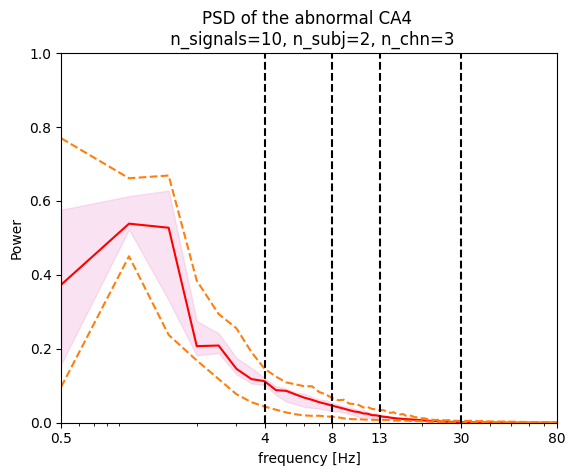

SRLM or 'dark band'
['003' '003' '003' '003' '083' '083' '083' '083' '083' '083' '083' '083'
 '083' '083' '083' '087' '087' '087' '087' '087' '087' '087' '087' '087'
 '087' '087' '087' '087' '087' '087' '087' '087' '087' '088' '088' '088'
 '088' '088' '088' '088' '088' '088' '095' '095' '095' '095' '095']
['RAHc3-4' 'RPHc2-3' 'RAHc3-4' 'RPHc2-3' 'LPHc1-2' 'LPHc1-2' 'LPHc1-2'
 'LPHc1-2' 'LPHc1-2' 'LPHc1-2' 'LPHc1-2' 'LPHc1-2' 'LPHc1-2' 'LPHc1-2'
 'LPHc1-2' 'RAHc2-3' 'RPHc2-3' 'RAHc2-3' 'RPHc2-3' 'RAHc2-3' 'RPHc2-3'
 'RAHc2-3' 'RPHc2-3' 'RAHc2-3' 'RPHc2-3' 'RAHc2-3' 'RPHc2-3' 'RAHc2-3'
 'RPHc2-3' 'RAHc2-3' 'RPHc2-3' 'RAHc2-3' 'RPHc2-3' 'LAHc2-3' 'LAHc2-3'
 'LAHc2-3' 'LAHc2-3' 'LAHc2-3' 'LAHc2-3' 'LAHc2-3' 'LAHc2-3' 'LAHc2-3'
 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2']


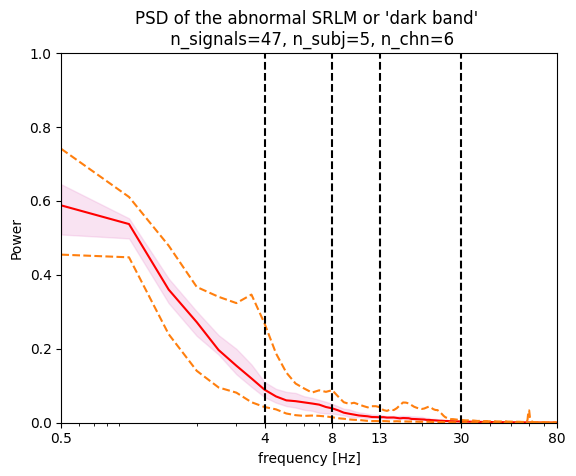

CA1
['003' '003' '004' '004' '004' '004' '004' '004' '004' '004' '081' '081'
 '081' '081' '081' '081' '081' '081' '081' '081' '087' '087' '087' '087'
 '087' '087' '087' '087' '087' '087' '087' '087' '087' '087' '087' '087'
 '087' '087' '087' '087' '087' '087' '087' '087' '087' '087' '087' '087'
 '087' '087' '087' '087' '087' '087' '087' '087' '087' '087' '087' '087'
 '087' '087' '087' '087' '087' '087' '087' '087' '087' '087' '087' '087'
 '087' '087' '095' '095' '095' '095' '095']
['RPHc1-2' 'RPHc1-2' 'LPHc2-3' 'LAHc2-3' 'LPHc2-3' 'LAHc2-3' 'LPHc2-3'
 'LAHc2-3' 'LPHc2-3' 'LAHc2-3' 'RPHc1-2' 'RPHc2-3' 'RPHc1-2' 'RPHc2-3'
 'RPHc1-2' 'RPHc2-3' 'RPHc1-2' 'RPHc2-3' 'RPHc1-2' 'RPHc2-3' 'LAHc1-2'
 'LAHc2-3' 'LPHc2-3' 'LPHc3-4' 'RAHc1-2' 'RAHc3-4' 'LAHc1-2' 'LAHc2-3'
 'LPHc2-3' 'LPHc3-4' 'RAHc1-2' 'RAHc3-4' 'LAHc1-2' 'LAHc2-3' 'LPHc2-3'
 'LPHc3-4' 'RAHc1-2' 'RAHc3-4' 'LAHc1-2' 'LAHc2-3' 'LPHc2-3' 'LPHc3-4'
 'RAHc1-2' 'RAHc3-4' 'LAHc1-2' 'LAHc2-3' 'LPHc2-3' 'LPHc3-4' 'RAHc1-2'
 'RAHc3-4' 'LAHc1

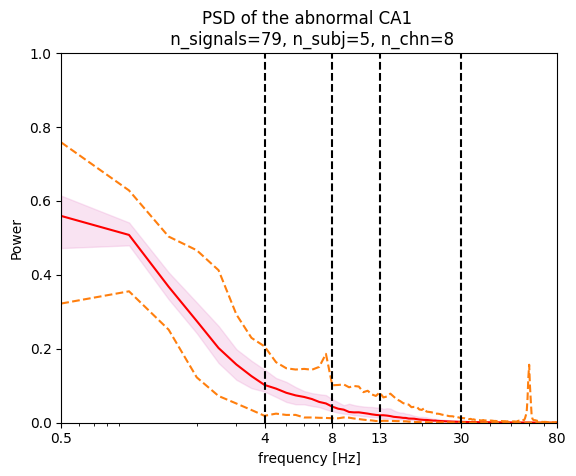

subiculum
['004' '004' '004' '004' '087' '087' '087' '087' '087' '087' '087' '087'
 '087']
['LAHc1-2' 'LAHc1-2' 'LAHc1-2' 'LAHc1-2' 'RPHc1-2' 'RPHc1-2' 'RPHc1-2'
 'RPHc1-2' 'RPHc1-2' 'RPHc1-2' 'RPHc1-2' 'RPHc1-2' 'RPHc1-2']


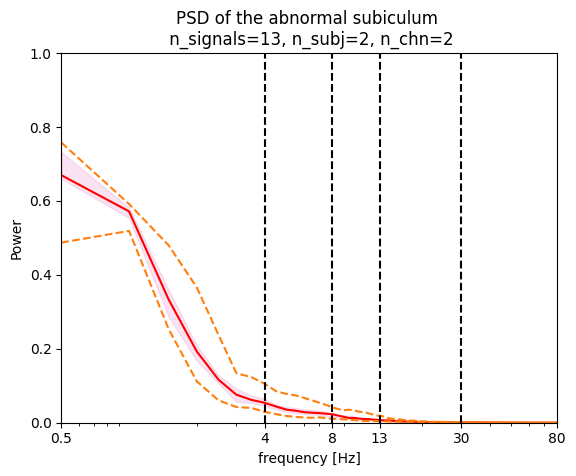

CA3
['065' '065' '081' '081' '081' '081' '081' '095' '095' '095' '095' '095']
['LPHc1-2' 'LPHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2' 'RAHc1-2'
 'LAHc1-2' 'LAHc1-2' 'LAHc1-2' 'LAHc1-2' 'LAHc1-2']


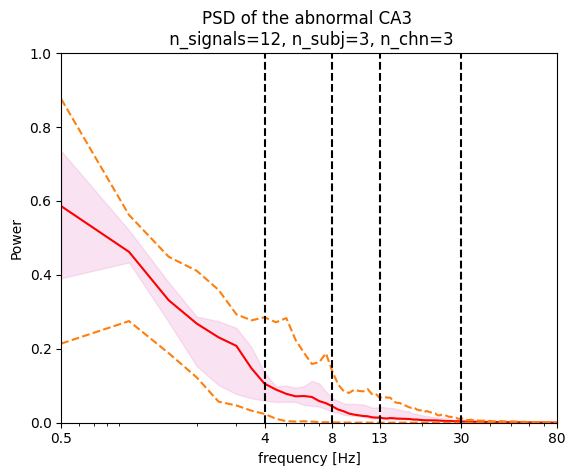

dentate gyrus
['082' '082' '082' '082' '082' '082']
['LAHc3-4' 'LAHc3-4' 'LAHc3-4' 'LAHc3-4' 'LAHc3-4' 'LAHc3-4']


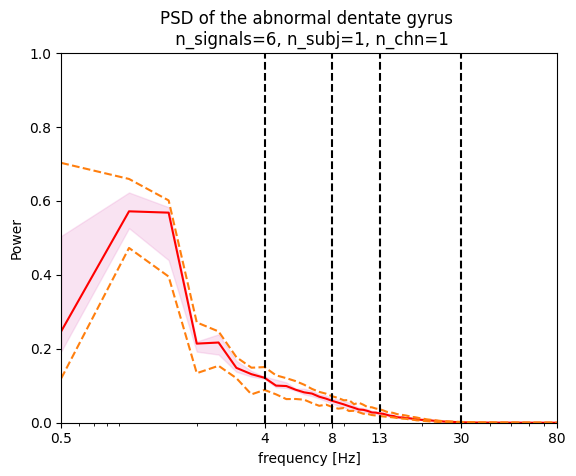

In [37]:
# Extract median, mean and std
median_region = {}
std_region = {}
mean_region = {}
for region in psd_per_region_ab:
    # Extract data
    print(region)
    print(abn_subj_per_region[region])
    print(abn_chn_per_region[region])
    psd = psd_per_region_ab[region]
    f = f_per_region_ab[region]
    # # Plot and save the median curve
    n_subj = len(np.unique(abn_subj_per_region[region]))
    n_chn = len(np.unique(abn_chn_per_region[region]))
    median, mean, std = plotPaperFigures(f, psd, show_fig=True, title=f'PSD of the abnormal {region} \n n_signals={psd.shape[0]}, n_subj={n_subj}, n_chn={n_chn}')
    median_region[region] = median
    std_region[region] = std
    mean_region[region] = mean